# COMPAS Analysis using Aequitas
In 2016, ProPublica reported on racial inequality in automated criminal risk assessment algorithms. The [report](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) is based on [this analysis](https://github.com/propublica/compas-analysis). Using a clean version of the COMPAS dataset from the ProPublica GitHub repo, we demostrate the use of the Aequitas bias reporting tool.

Northpointe's COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is one of the widest used risk assessment tools, algorithms which are used in the criminal justice system to guide decisions such as how to set bail. The ProPublica dataset represents two years of COMPAS predicitons from Broward County, FL.

Analysis by Ari Anisfeld and Abby Stevens.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import re
import math

%matplotlib inline

/Users/lorenh/Documents/DSaPP/.aequitas/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df = pd.read_csv("../../../examples/data/compas_for_aequitas.csv")
df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


In [3]:
df.shape

(7214, 6)

Data for this example was preprocessed for compatibility with Aequitas. **The Aequitas tool always requires a `score` column and requires a binary `label_value` column for supervised metrics**, (i.e., False Discovery Rate, False Positive Rate, False Omission Rate, and False Negative Rate).

Preprocessing includes but is not limited to checking for mandatory `score` and `label_value` columns as well as at least one column representing attributes specific to the data set. See [documentation](../input_data.html) for more information about input data.

Note that while `entity_id` is not necessary for this example, Aequitas recognizes `entity_id` as a reserve column name and will not recognize it as an attribute column.

## Exploratory Analysis

__Risk assessment by race__

COMPAS produces a risk score that predicts a person's likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of "low" risk according to COMPAS, while a 1 indicates "high" or "medium" risk.

This categorization is based on ProPublica's interpretation of Northpointe's practioner guide:

    "According to Northpointe’s practitioners guide, COMPAS “scores in the medium and high range garner more interest from supervision agencies than low scores, as a low score would suggest there is little risk of general recidivism,” so we considered scores any higher than “low” to indicate a risk of recidivism."

In the bar charts below, we see a large difference in how these scores are distributed by race, with a majority of white and Hispanic people predicted as low risk (score = 0) and a majority of black people predicted high and medium risk (score = 1). We also see that while the majority of people in age categories over 25 are predicted as low risk (score = 0), the majority of people below 25 are predicted as high and medium risk (score = 1).

In [4]:
aq_palette = sns.diverging_palette(215, 35, n=2)

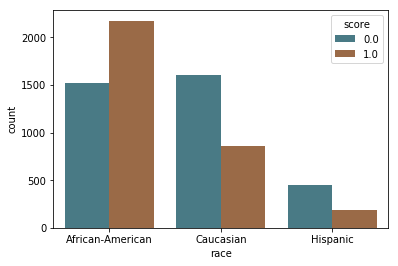

In [5]:
by_race = sns.countplot(x="race", hue="score", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=aq_palette)

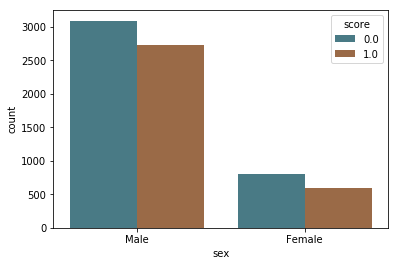

In [6]:
by_sex = sns.countplot(x="sex", hue="score", data=df, palette=aq_palette)

We note that for people under 25, COMPAS predicts higher risk at a higher rate for this younger age group than older age groups.

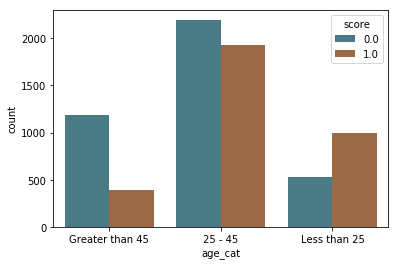

In [7]:
by_age = sns.countplot(x="age_cat", hue="score", data=df, palette=aq_palette)

__Levels of recidivism__

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race. 

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"




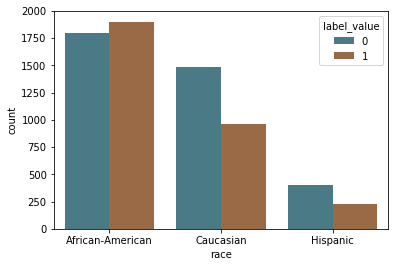

In [8]:
label_by_race = sns.countplot(x="race", hue="label_value", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=aq_palette)

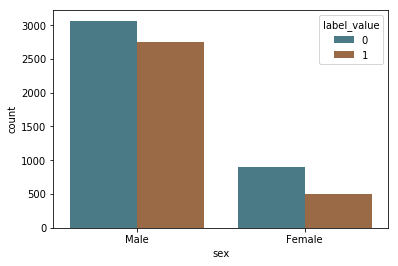

In [9]:
label_by_age = sns.countplot(x="sex", hue="label_value", data=df, palette=aq_palette)

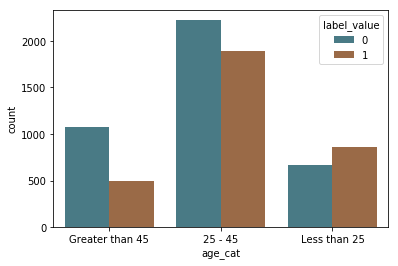

In [10]:
label_by_sex = sns.countplot(x="age_cat", hue="label_value", data=df, palette=aq_palette)

## Putting Aequitas to the task

The graph above shows the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39). The prior graph shows that the predictions do not match the base rates. 

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that we have multiple ways to measure bias adds complexity to the decisionmaking process. With Aequitas, we provide a tool that automates the reporting of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes: 

`Group()`: Define groups 

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.


## Group()
Aequitas expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this cases we include `race`, `sex` and `age_cat`. 

In [11]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 1 {'rank_abs': [3317]}
COUNTS::: race
African-American    3696
Asian                 32
Caucasian           2454
Hispanic             637
Native American       18
Other                377
dtype: int64
COUNTS::: sex
Female    1395
Male      5819
dtype: int64
COUNTS::: age_cat
25 - 45            4109
Greater than 45    1576
Less than 25       1529
dtype: int64


The **`get_crosstabs()`** command tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

#### Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calcuated:

| Metric | Column Name |
| --- | --- |
| $True Positive Rate$ | 'tpr' |
| $True Negative Rate$ | 'tnr' |
| $False Omission Rate$ | 'for' |
| $False Discovery Rate$ | 'fdr' |
| $False Positive Rate$ | 'fpr' |
| $False Negative Rate$ | 'fnr' |
| $Negative Predictive Value$ | 'npv' |
| $Precision$ | 'precision' |
| $Predicted Positive Ratio_k$ | 'ppr' |
| $Predicted Positive Ratio_g$ | 'pprev' |
| $Prevalence$ | 'prev' |

The results are appended to the base (original) dataframe. We see a slice of this below.

In [12]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [13]:
# View subset of calculated absolute metrics 
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,ppr,pprev,fdr,prev,tpr,tnr,fpr,for,npv,fnr,precision
0,race,African-American,0.66,0.59,0.37,0.51,0.72,0.55,0.45,0.35,0.65,0.28,0.63
1,race,Asian,0.00,0.25,0.25,0.28,0.67,0.91,0.09,0.12,0.88,0.33,0.75
2,race,Caucasian,0.26,0.35,0.41,0.39,0.52,0.77,0.23,0.29,0.71,0.48,0.59
3,race,Hispanic,0.06,0.30,0.46,0.36,0.44,0.79,0.21,0.29,0.71,0.56,0.54
4,race,Native American,0.00,0.67,0.25,0.56,0.90,0.62,0.38,0.17,0.83,0.10,0.75
5,race,Other,0.02,0.21,0.46,0.35,0.32,0.85,0.15,0.30,0.70,0.68,0.54
6,sex,Female,0.18,0.42,0.49,0.36,0.61,0.68,0.32,0.24,0.76,0.39,0.51
7,sex,Male,0.82,0.47,0.36,0.47,0.63,0.68,0.32,0.33,0.67,0.37,0.64
8,age_cat,25 - 45,0.58,0.47,0.39,0.46,0.63,0.67,0.33,0.32,0.68,0.37,0.61
9,age_cat,Greater than 45,0.12,0.25,0.46,0.32,0.43,0.83,0.17,0.24,0.76,0.57,0.54


__Interpreting the crosstab__ 
We see that African-Americans have a false positive rate (`fpr`) of 45%, while Caucasians have a false positive rate of only 23%. This means that African-American people are far more likely to be falsely labeled as high-risk than white people. On the other hand, false ommision rates (`for`) and false discovery rates (`fdr`) are much closer for those two groups.

## Visualizing Bias Metrics

For visualizing absolute metric fairness, a particular metric can be specified with **`plot_group_metric()`**. A list of particular metrics of interest or 'all' metrics can be plotted with **`plot_group_metric_all()`**.

In [14]:
aqp = Plotting()

### Specifying a single absolute group metric
The chart below displays group metric Predicted Positive Rate Disparity (ppr) calculated across each attribute, colored based on absolute metric magnitude.

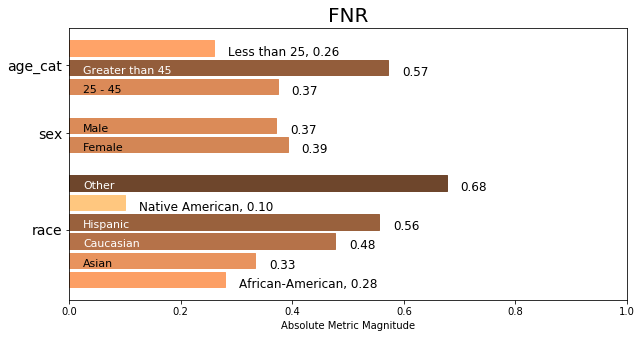

In [15]:
fnr = aqp.plot_group_metric(xtab, 'fnr')

### Default absolute group metrics
The charts below displays the default group metrics calculated across each attribute, colored based on absolute metric magnitude.

Default metrics: 
- Predicted Positive Group Rate Disparity (pprev), 
- Predicted Positive Rate Disparity (ppr),  
- False Discovery Rate (fdr), 
- False Omission Rate (for)
- False Positive Rate (fpr)
- False Negative Rate (fnr)

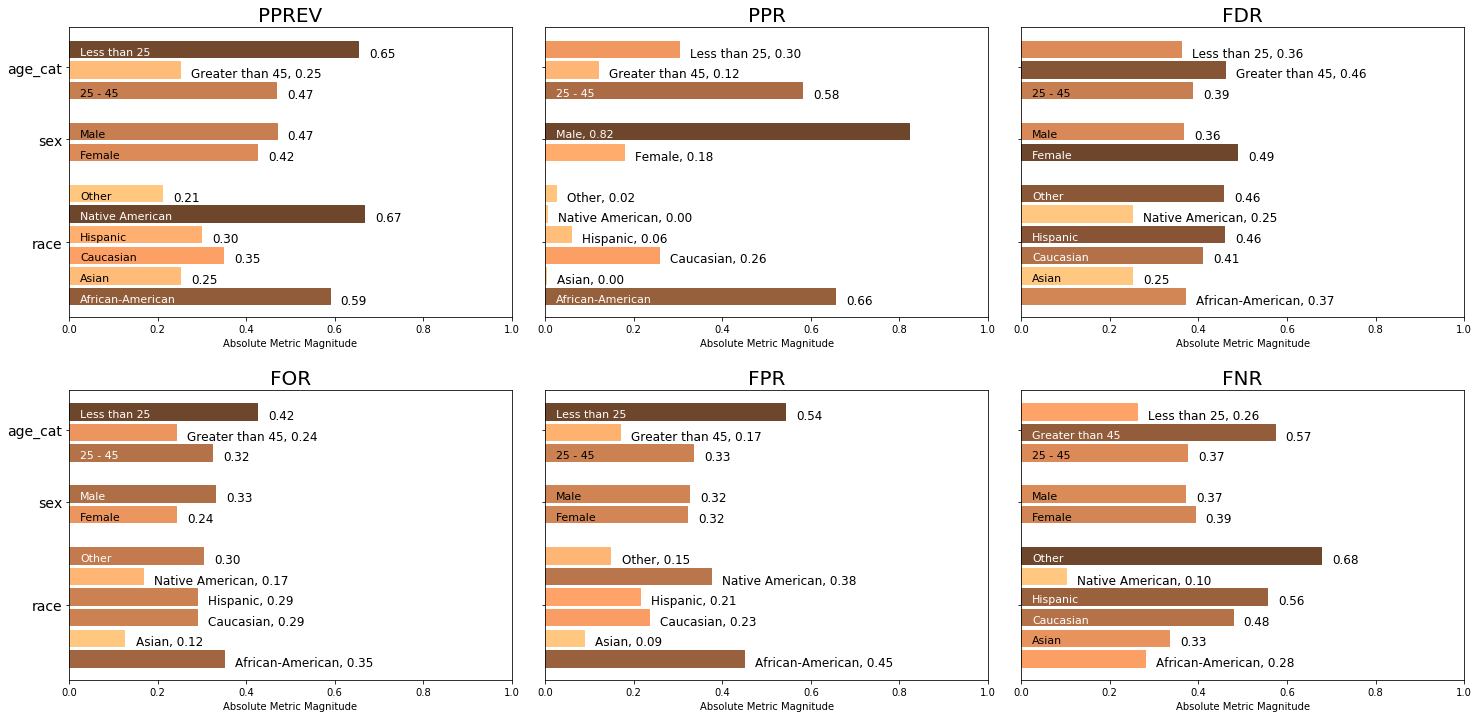

In [16]:
a = aqp.plot_group_metric_all(xtab)

### Specifying all absolute group metrics

The charts below display the all calculated group metrics across each attribute, colored based on absolute metric magnitude.

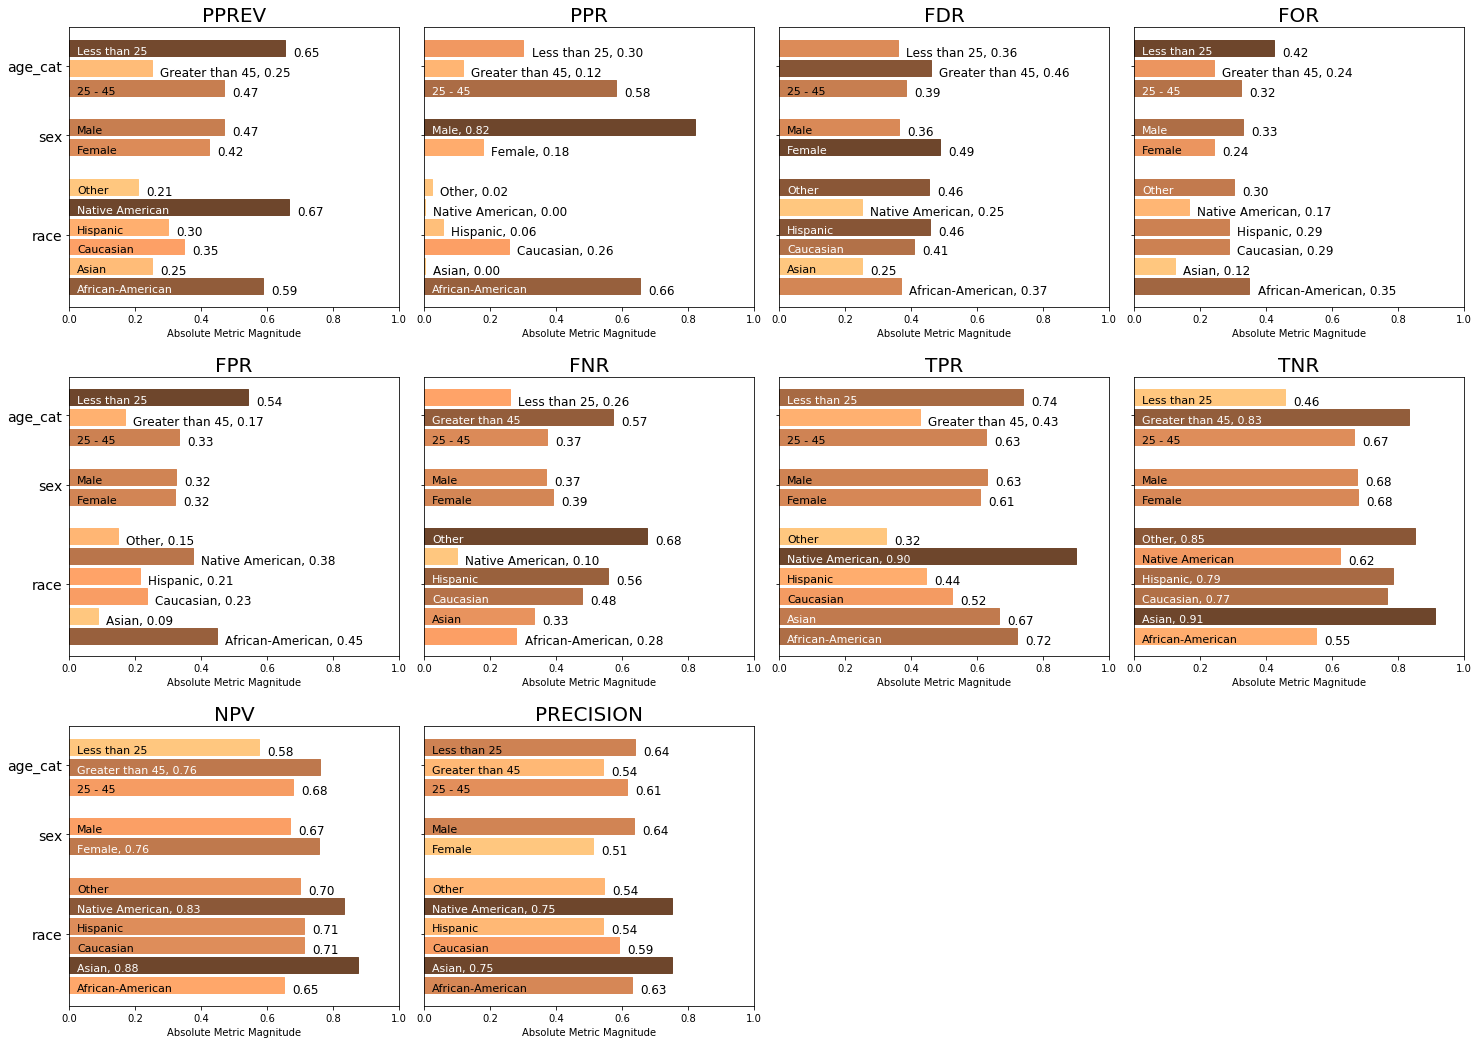

In [17]:
p = aqp.plot_group_metric_all(xtab, metrics='all', ncols=4)

## Bias()
We calculate disparities as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$ 

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner. 

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.  

In [18]:
b = Bias()

#### Calculate disparities in relation a predefinied group for each attribute

In [19]:
bdf = b.get_disparity_predefined_groups(xtab, {'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'})

get_disparity_predefined_group()


In [20]:
hbdf = b.get_disparity_predefined_groups(xtab, {'race':'Hispanic', 'sex':'Male', 'age_cat':'25 - 45'})

get_disparity_predefined_group()


#### Calculate disparities in relation to the sample majority group for each attribute

In [21]:
majority_bdf = b.get_disparity_major_group(xtab)

get_disparity_major_group()


#### Calculate disparities in relation to the minimum value for each metric

In [22]:
min_metric_bdf = b.get_disparity_min_metric(xtab)

get_disparity_min_metric()
get_disparity_min_metric


#### Disparities Calculated Calcuated:

| Metric | Column Name |
| --- | --- |
| $True Positive Rate Disparity$ | 'tpr_disprity' |
| $True Negative Rate$ | 'tnr_disparity' |
| $False Omission Rate$ | 'for_disparity' |
| $False Discovery Rate$ | 'fdr_disparity' |
| $False Positive Rate$ | 'fpr_disparity' |
| $False NegativeRate$ | 'fnr_disparity' |
| $Negative Predictive Value$ | 'npv_disparity' |
| $Precision Disparity$ | 'precision_disparity' |
| $Predicted Positive Ratio_k Disparity$ | 'ppr_disparity' |
| $Predicted Positive Ratio_g Disparity$ | 'pprev_disparity' |


Columns for each disparity are appended to the crosstab dataframe, along with a column indicating the reference group for each calculated metric (denoted by `[metric name]_ref_group_value`). We see a slice of the dataframe with calculated metrics below.

In [23]:
calculated_disparities = b.list_disparities(bdf)

In [24]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,race,African-American,2.545667,1.690224,1.064904,0.906085,1.213154,1.912093,0.586416,1.377549,0.720526,0.913728
1,race,Asian,0.009368,0.718384,1.268317,0.611748,0.433839,0.370749,0.698482,1.275248,1.192808,1.229148
2,race,Caucasian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,race,Hispanic,0.222482,0.857099,0.916748,1.120464,1.001616,0.915887,1.165140,0.849249,1.025773,0.999346
4,race,Native American,0.014052,1.915691,1.268317,0.611748,0.578453,1.598854,0.209544,1.721584,0.816506,1.170618
5,race,Other,0.092506,0.602147,0.920466,1.115085,1.048203,0.629057,1.417970,0.618447,1.113660,0.980490
6,sex,Female,0.216801,0.904348,0.806925,1.336425,0.734738,0.990343,1.055810,0.967101,1.004633,1.130710
7,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,age_cat,Greater than 45,0.204782,0.533914,0.879232,1.192804,0.746232,0.503031,1.531238,0.682963,1.248989,1.121136


__Interpreting the disparity ratios__
The differences in False Positive Rates, noted in the discussion of the Group() class above, are clarified using the disparity ratio (`fpr_disparity`). Black people are falsely identified as being high or medium risks 1.9 times the rate for white people. 

As seen above, False Discovery Rates have much less disparity (`fdr_disparity`), or fraction of false postives over predicted positive in a group. **Reference groups have disparity = 1 by design in Aequitas**, so the lower disparity is highlighted by the `fdr_disparity` value close to 1.0 (0.906) for the race attribute group 'African-American' when disparities are calculated using predefined base group 'Caucasian'. 

Note that COMPAS is calibrated to  balance False Positive Rate and False Discovery Rates across groups.


### Visualizing Bias Disparity

To visualize disparities, a particular disparity metric can be specified with **`plot_disparity()`**. To plot a single disparity, a metric and an attribute must be specified.

Disparities related to a list of particular metrics of interest or `'all'` metrics can be plotted with **`plot_disparity_all()`**.  At least one metric or at least one attribute must be specified when plotting multiple disparities (or the same disparity across multiple attributes). For example, to plot PPR and and Precision disparity for all attributes, specify `metrics=['ppr', 'precision']` with no attribute specified, and to plot default metrics by race, specify `attributes=['race']` and with no metrics specified.

**Reference groups are displayed in grey, and always have a disparity = 1.** Note that disparities greater than 10x reference group will are visualized as 10x, and disparities less than 0.1x reference group are visualized as 0.1x.

### Specifying one attribute and one disparity metric

The treemap below displays precision disparity values calculated using the minimum value of the metric, in this case, the 'Hispanic' group within the race attribute, colored based on disparity magnitude.

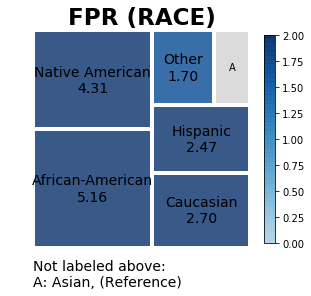

In [25]:
aqp.plot_disparity(min_metric_bdf, group_metric='fpr', attribute_name='race')

Note the differences in the visualiztion of disparity values when another group, 'Caucasian', is the reference group.

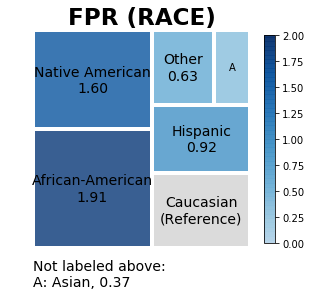

In [26]:
aqp.plot_disparity(bdf, group_metric='fpr', attribute_name='race')

### Specifying one disparity metric across all attributes

The treemaps belows display False Positive Rate disparities calculated based on predefined reference groups ('race' attribute: Hispanic, 'sex' attribute: Male, 'age_cat' attribute: 25-45), colored based on disparity magnitude.

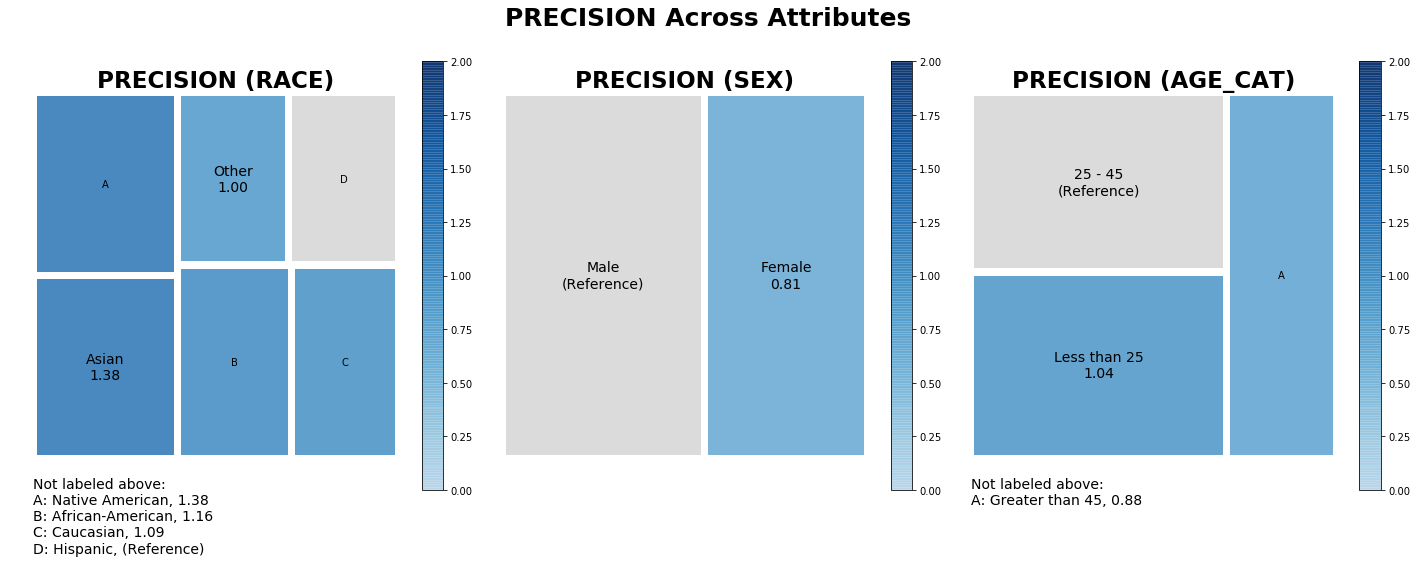

In [27]:
j = aqp.plot_disparity_all(hbdf, metrics=['precision'])

### Specifying one attribute for default disparity metrics
The treemaps below display the listed disparities between 'age_cat' groups calculated based on the minimum value of each metric, colored based on disparity magnitude.

Default metrics: 
- Predicted Positive Group Rate Disparity (pprev), 
- Predicted Positive Rate Disparity (ppr),  
- False Discovery Rate (fdr), 
- False Omission Rate (for)
- False Positive Rate (fpr)
- False Negative Rate (fnr)

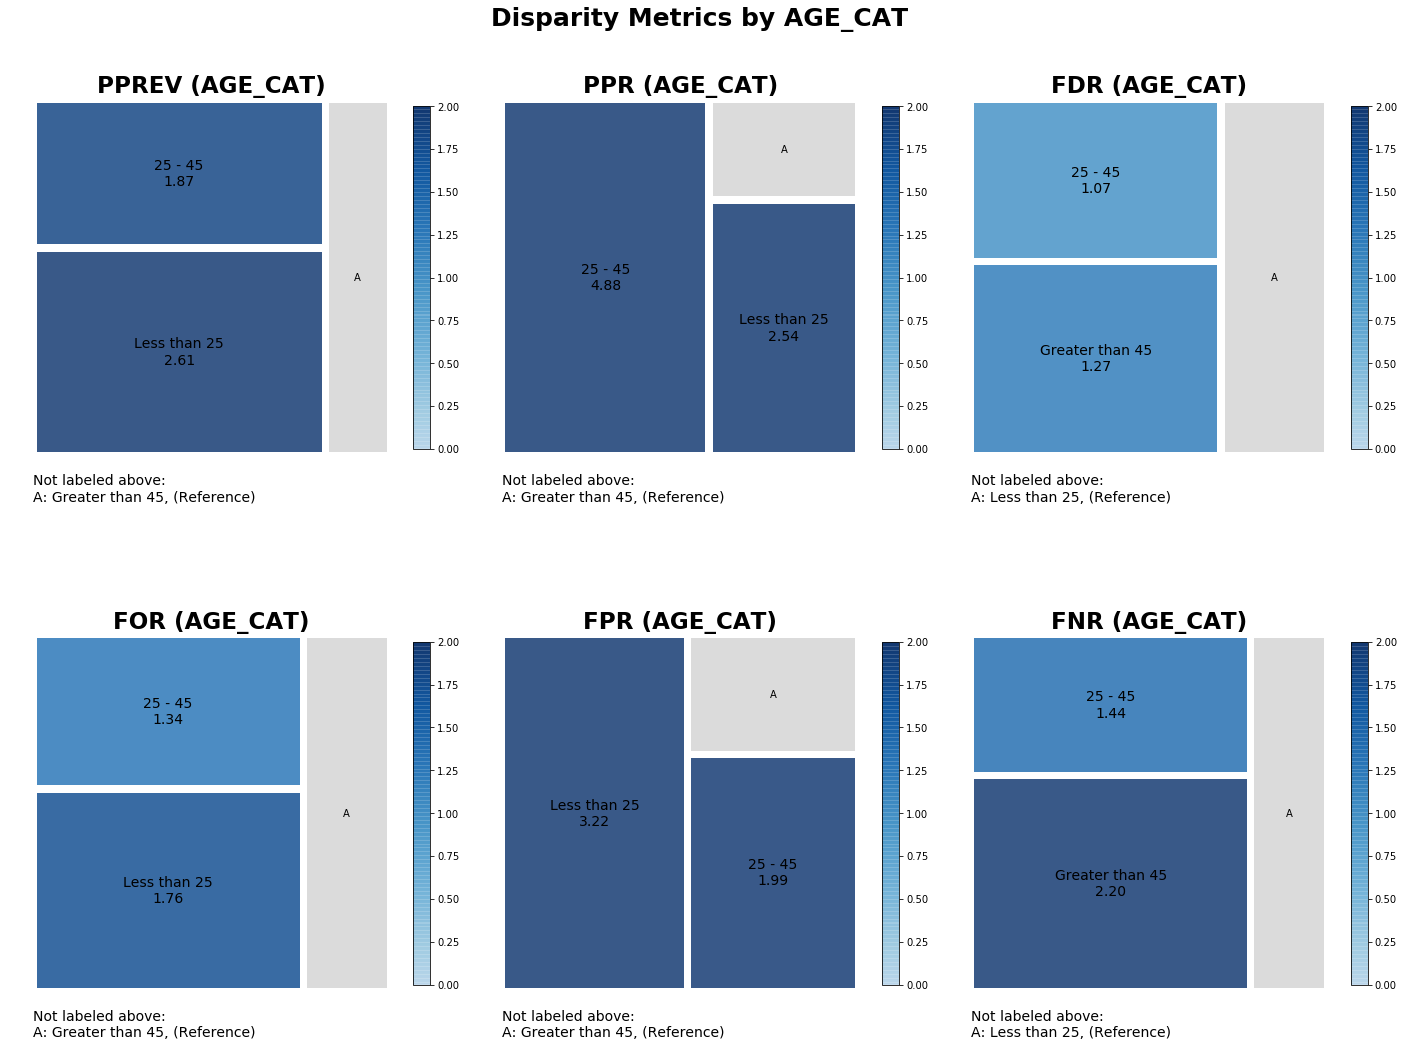

In [28]:
min_met = aqp.plot_disparity_all(min_metric_bdf, attributes=['age_cat'])

### Specifying all disparity metrics across one attribute

The treemaps below display disparities between 'race' attribute groups calculated based on predefined reference groups ('race' attribute: Hispanic, 'sex' attribute: Male, 'age_cat' attribute: 25-45) for all 10 disparity metrics, colored based on disparity magnitude.

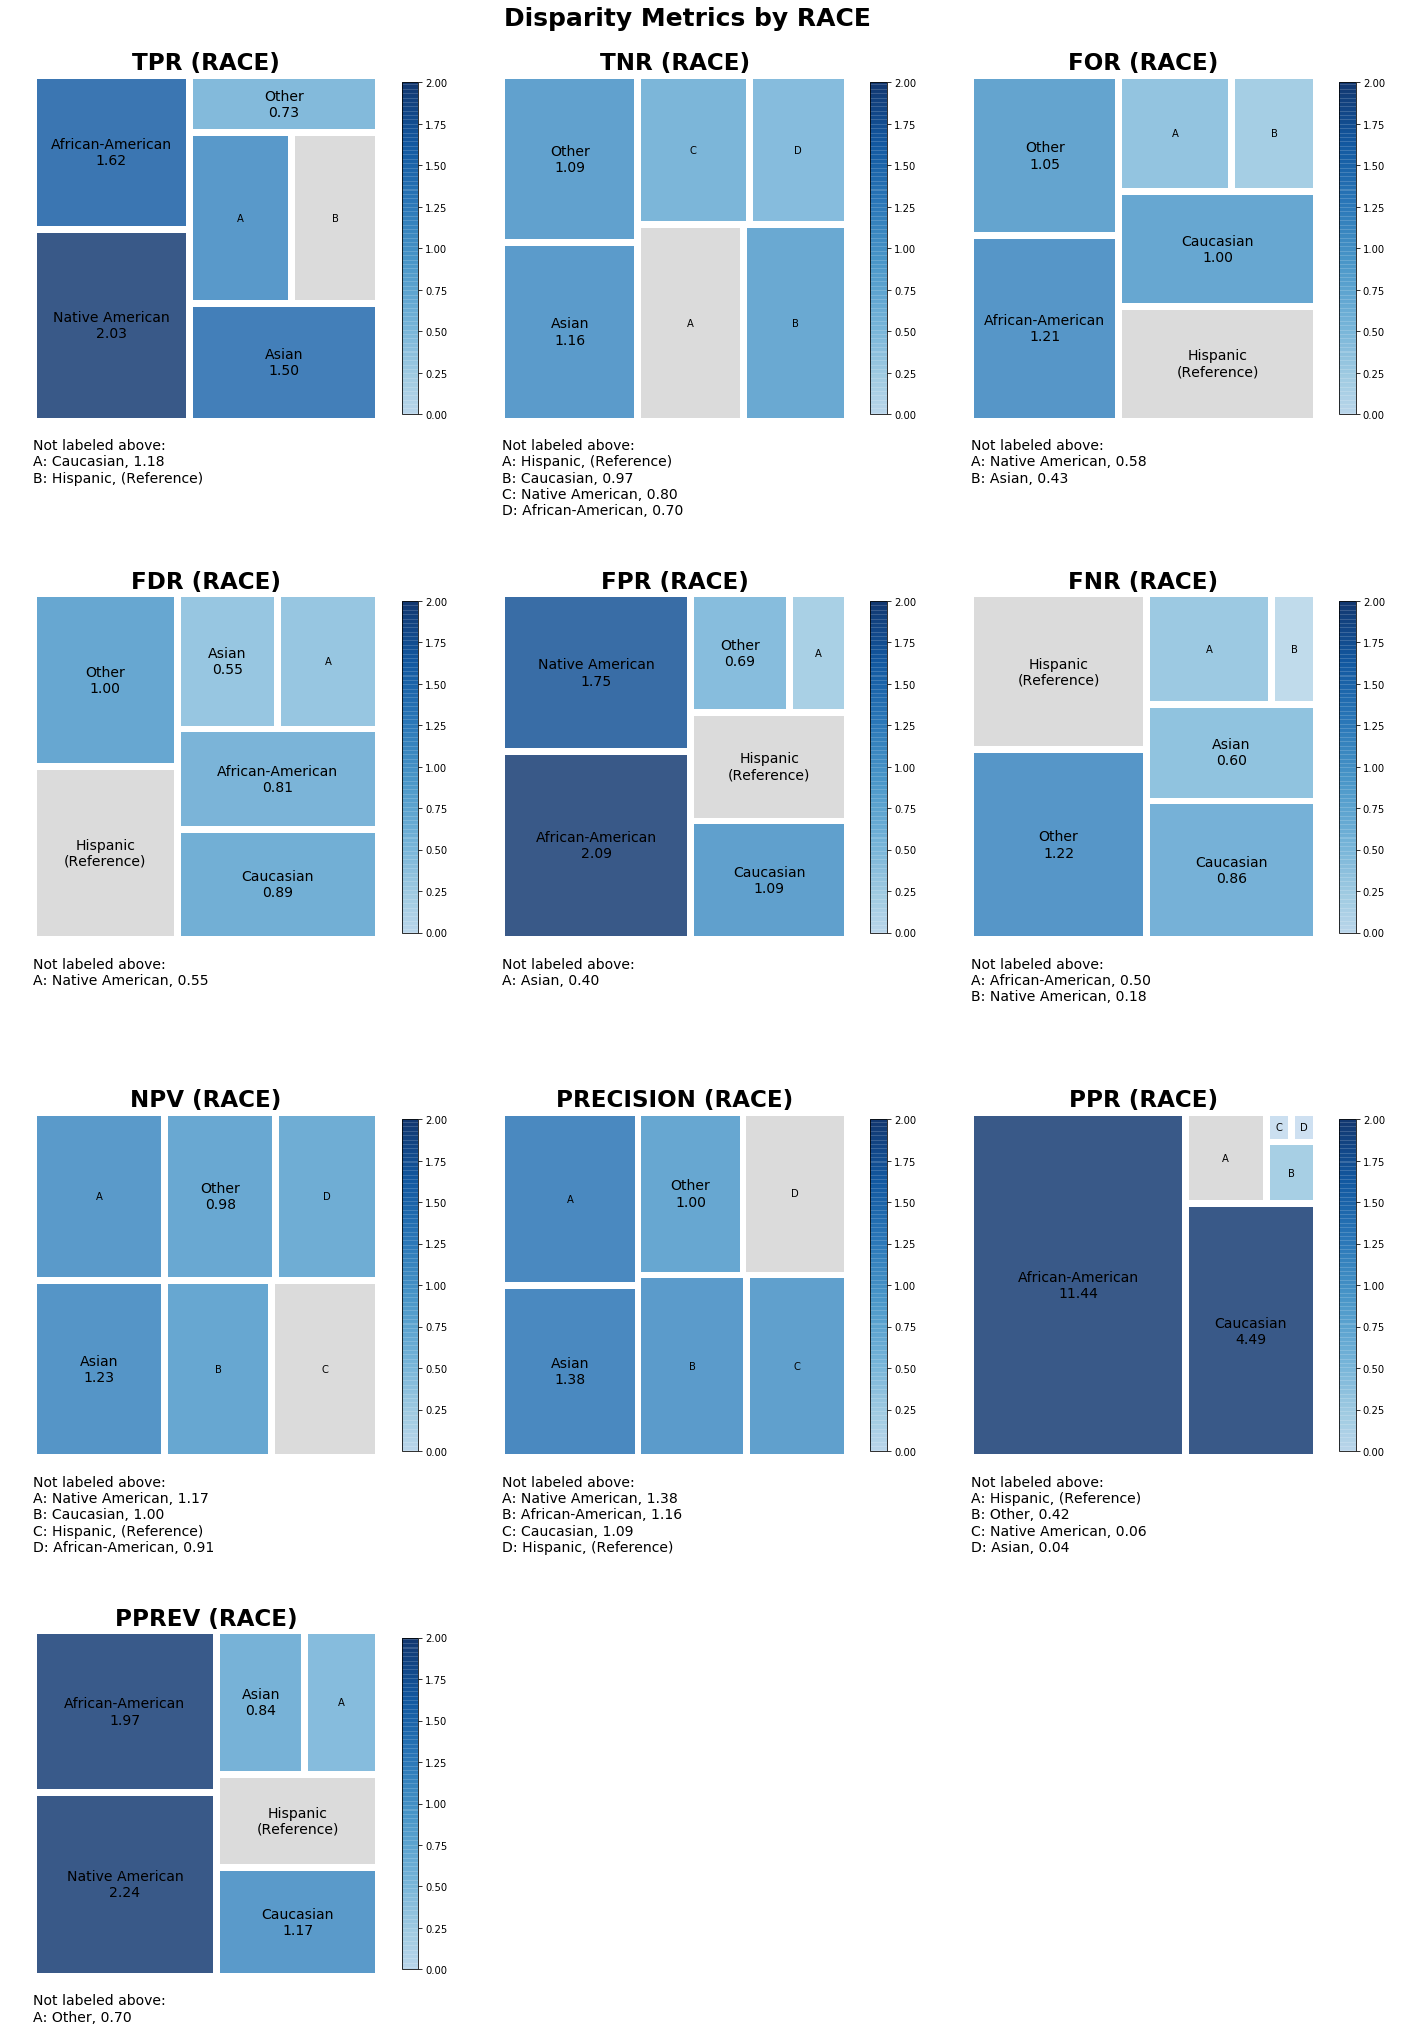

In [29]:
tm_capped = aqp.plot_disparity_all(hbdf, attributes=['race'], metrics = 'all')

### Specifying multiple disparity metrics across all attributes

The treemaps below display False Omission Rate, False Discovery Rate, and False Positive Rate disparities (calculated in relation to the sample majority group for each attribute) between groups acorss all three attributes, colored based on disparity magnitude.

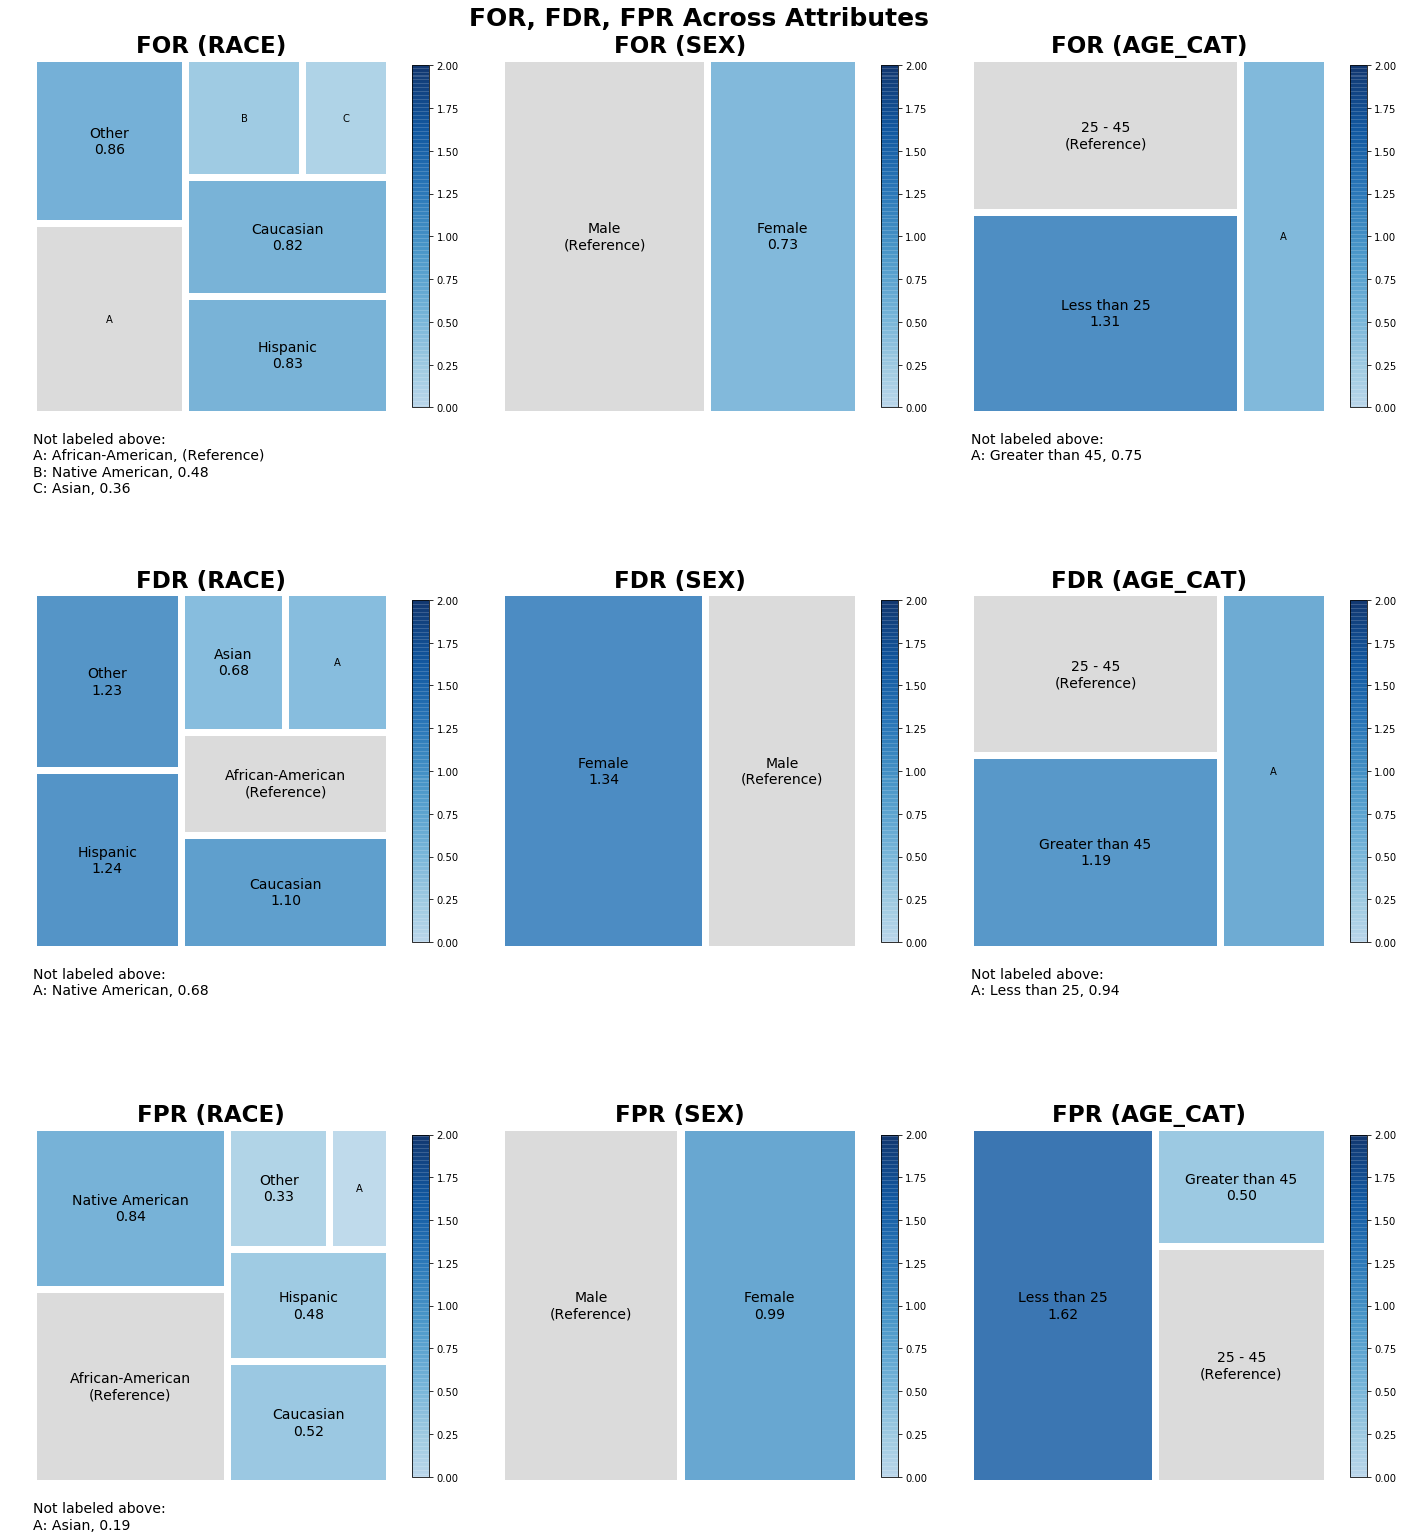

In [30]:
dp = aqp.plot_disparity_all(majority_bdf, metrics=['for', 'fdr', 'fpr'], ncols=3)

## Fairness()
Finally, the `Fairness()` class provides three functions that provide a high level summary. Using FPR disparity as an example and the default fairness threshold, we have:

$$ 0.8 < Disparity_{FNR} =  \frac{FPR_{group}}{FPR_{base group}} < 1.25 $$ 

In [31]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

#### We can assess fairness at various levels of detail:

The **`get_group_value_fairness()`** function builds on the previous dataframe. The **`get_group_value_fairness()`**
function gives us attribute group-level statistics for fairness determinations:

#### Pairities Calcuated:

| Parity | Column Name |
| --- | --- |
| $True Positive Rate Parity$ | 'TPR Parity' |
| $True Negative Rate Parity$ | 'TNR Parity' |
| $False Omission Rate Parity$ | 'FOR Parity' |
| $False Discovery Rate Parity$ | 'FDR Parity' |
| $False Positive Rate Parity$ | 'FPR Parity' |
| $False Negative Rate Parity$ | 'FNR Parity' |
| $Negative Predictive Value Parity$ | 'NPV Parity' |
| $Precision Parity$ | 'Precision Parity' |
| $Predicted Positive Ratio_k Parity$ | 'Statistical Parity' |
| $Predicted Positive Ratio_g Parity$ | 'Impact Parity' |

#### Also assessed:
- **_Type I Parity_**: Fairness in both FDR Parity and FPR Parity
- **_Type II Parity_**: Fairness in both FOR Parity and FNR Parity
- **_Equalized Odds_**: Fairness in both FPR Parity and TPR Parity
- **_Unsupervised Fairness_**: Fairness in both Statistical Parity and Impact Parity
- **_Supervised Fairness_**: Fairness in both Type I and Type II Parity
- **_Overall Fairness_**: Fairness across all parities for all attributes

In [32]:
fairness_grid = fdf[['attribute_name', 'attribute_value','Statistical Parity',
       'Impact Parity', 'FDR Parity', 'FPR Parity', 'FOR Parity', 'FNR Parity',
       'TypeI Parity', 'TypeII Parity', 'Unsupervised Fairness',
       'Supervised Fairness']]
fairness_grid

,attribute_name,attribute_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TypeI Parity,TypeII Parity,Unsupervised Fairness,Supervised Fairness
0,race,African-American,False,False,True,False,True,False,False,False,False,False
1,race,Asian,False,False,False,False,False,False,False,False,False,False
2,race,Caucasian,True,True,True,True,True,True,True,True,True,True
3,race,Hispanic,False,True,True,True,True,True,True,True,False,True
4,race,Native American,False,False,False,False,False,False,False,False,False,False
5,race,Other,False,False,True,False,True,False,False,False,False,False
6,sex,Female,False,True,False,True,False,True,False,False,False,False
7,sex,Male,True,True,True,True,True,True,True,True,True,True
8,age_cat,25 - 45,True,True,True,True,True,True,True,True,True,True
9,age_cat,Greater than 45,False,False,True,False,False,False,False,False,False,False


__Interpreting parity__ In this case, our base groups are Caucasian for race, Male for gender, and 25-45 for age_cat. By construction, the base group has supervised fairness. (The disparity ratio is 1). Relative to the base groups, the COMPAS predictions only provide supervised fairness to one group, Hispanic.

Above, the African-American false omission and false discovery are within the bounds of fairness. This result is expected because COMPAS is calibrated. (Given calibration, it is surprising that Asian and Native American rates are so low. This may be a matter of having few observations for these groups.)

On the other hand, African-Americans are roughly twice as likely to have false positives and 40 percent less likely to false negatives. In real terms, 44.8% of African-Americans who did not recidivate were marked high or medium risk (with potential for associated penalties), compared with 23.4% of Caucasian non-reoffenders. This is unfair and is marked False below.

These findings mark an inherent trade-off between FPR Fairness, FNR Fairness and calibration, which is present in any decision system where base rates are not equal. See [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas helps bring this trade-off to the forefront with clear metrics and asks system designers to make a reasoned decision based on their use case.

Use the **`get_group_attribute_fairness()`** function to view only the calculated parities from the **`get_group_value_fairness()`** function at the attribute level.

In [33]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,age_cat,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
1,1,binary 0/1,race,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,1,binary 0/1,sex,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False


The **`get_overall_fairness()`** function gives a quick boolean assessment of the output of **`get_group_attribute_fairness()`**, returning a determination across all attributes for each of:
- Unsupervised Fairness
- Supervised Fairness
- Overall Fairness

In [34]:
gof = f.get_overall_fairness(gaf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

## Visualizing Bias Metric Parity

For visualizing absolute metric fairness, a particular metric can be specified with **`plot_fairness_group()`**. A list of particular metrics of interest or 'all' metrics can be plotted with **`plot_fairness_group_all()`**.

### Specifying a single absolute group metric

The chart below displays absolute group metric Predicted Positive Rate Disparity (ppr) across each attribute, colored based on fairness determination for that attribute group (green = 'True' and red = 'False').

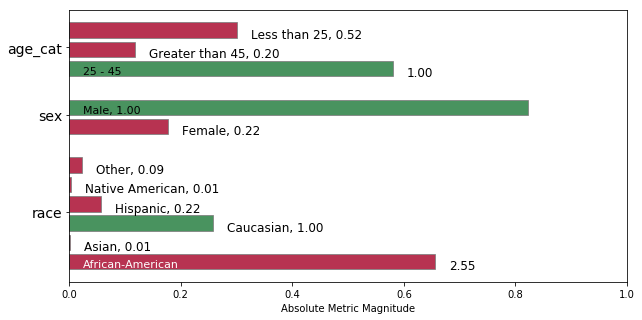

In [35]:
aqp.plot_fairness_group(fdf, group_metric='ppr')
plt.show()

### Specifying all absolute group metrics

The charts below display all calculated absolute group metrics across each attribute, colored based on fairness determination for that attribute group (green = 'True' and red = 'False').

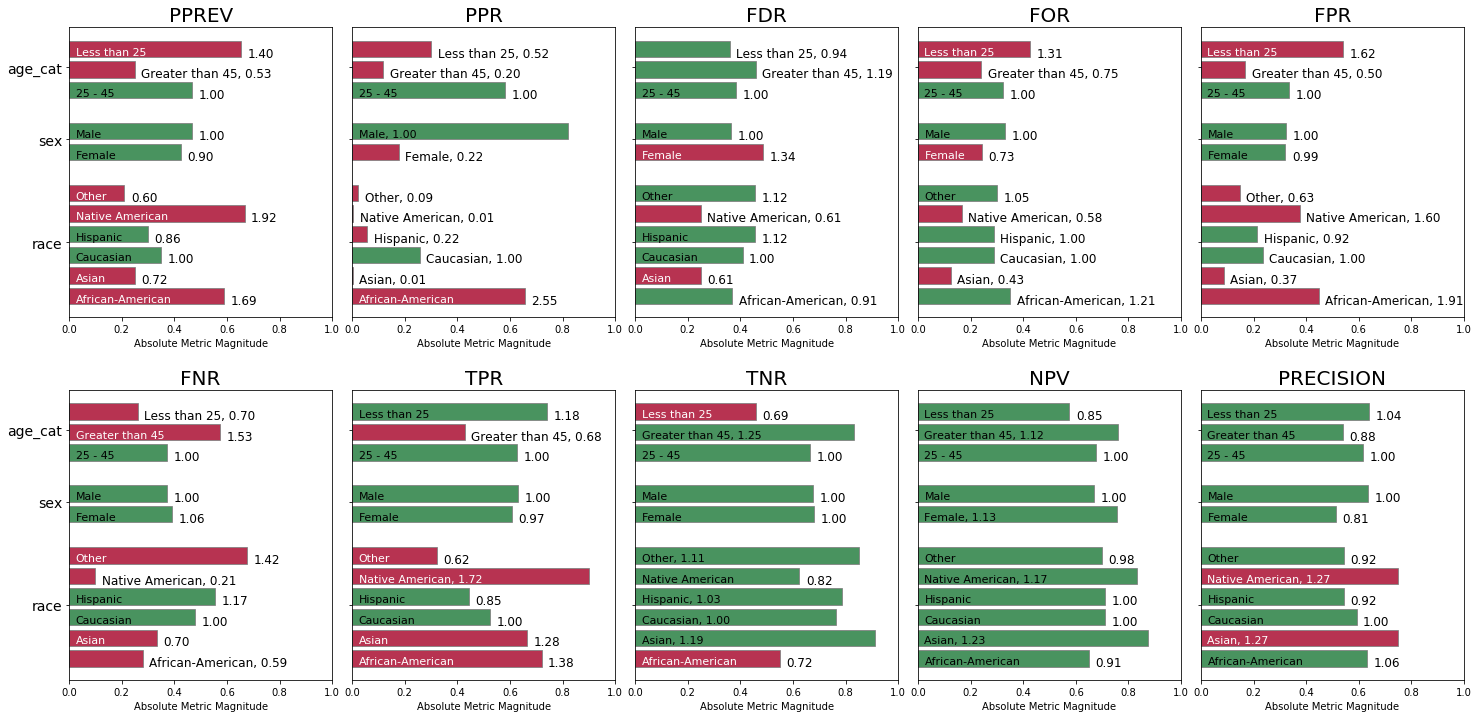

In [36]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")


## Visualizing Disparity Fairness

To visualize disparity fairness, a particular disparity metric can be specified with **`plot_fairness_disparity()`**. To plot a single disparity, a metric and an attribute must be specified.

Disparities related to a list of particular metrics of interest or `'all'` metrics can be plotted with **`plot_fairness_disparity_all()`**. At least one metric or at least one attribute **must** be specified when plotting multiple fairness disparities (or the same disparity across multiple attributes).

### Specifying one disparity metric and one attribute

The treemap below displays False Discovery Rate disparity values between race attribute groups calculated based on a predefined reference group ('Caucasian'), colored based on fairness determination for that attribute group (green = 'True' and red = 'False').

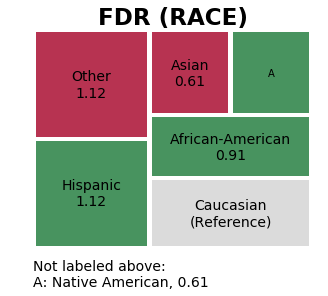

In [37]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='race')

### Specify multiple disparity metrics for one attribute

The treemaps below display disparities between race attribute groups calculated based on a predefined reference group ('Caucasian') for all 10 disparity metrics, colored based on fairness determination for that attribute group (green = 'True' and red = 'False').

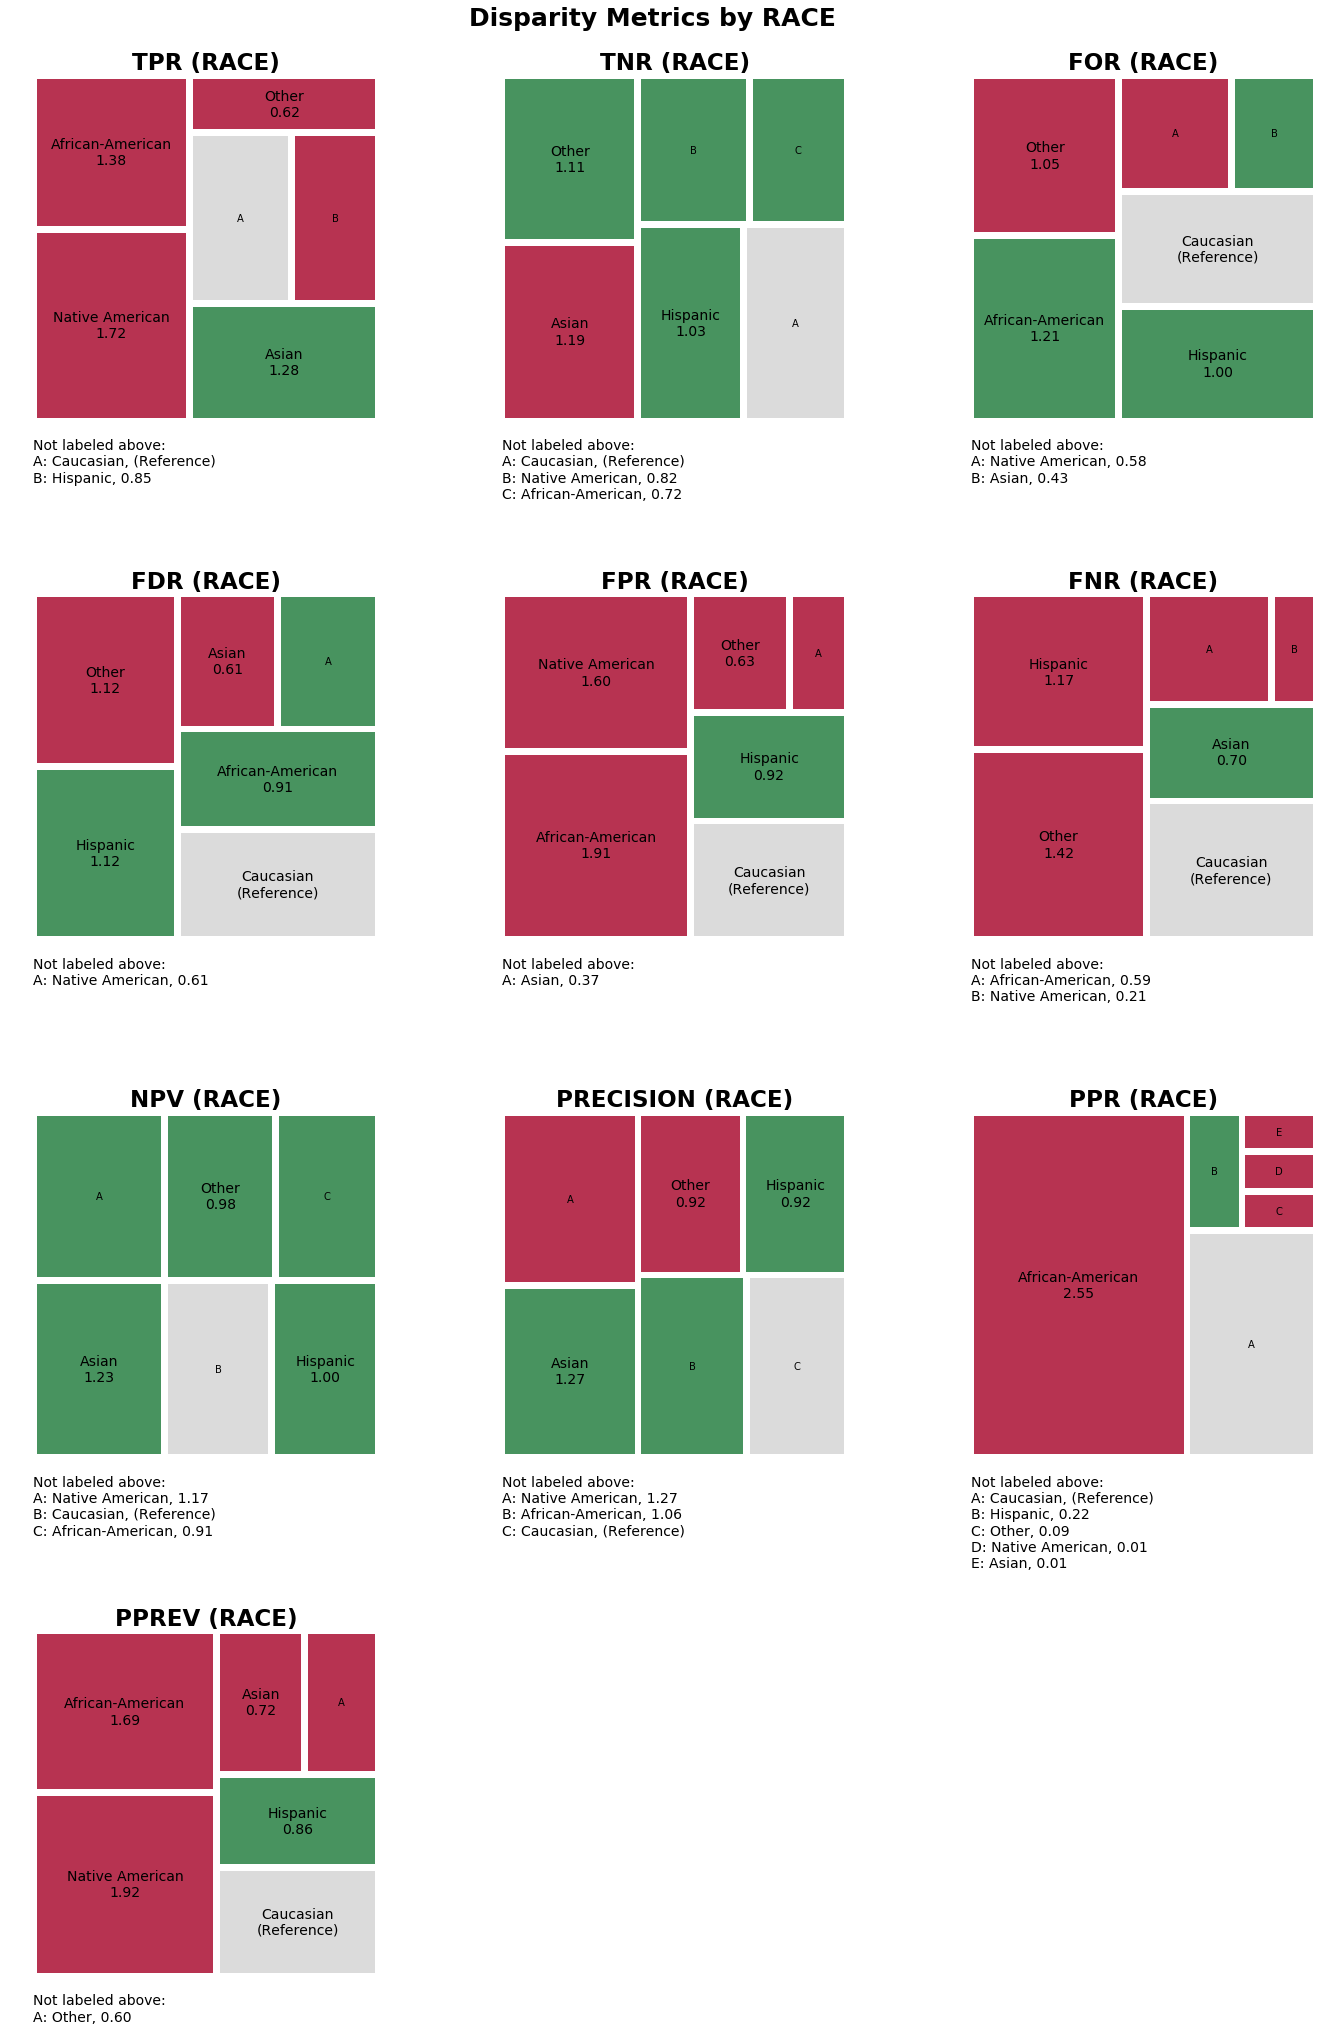

In [38]:
a_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['race'], metrics='all')

### Specify multiple disparity metrics across all attributes

The treemaps below display Predicted Positive Group Rate (pprev) and Predicted Positive Rate (ppr) disparities between attribute groups for all three attributes (race, sex, age category) calculated based on predefined reference groups ('race' attribute: Caucasian, 'sex' attribute: Male, 'age_cat' attribute: 25-45), colored based on fairness determination for that attribute group (green = 'True' and red = 'False').

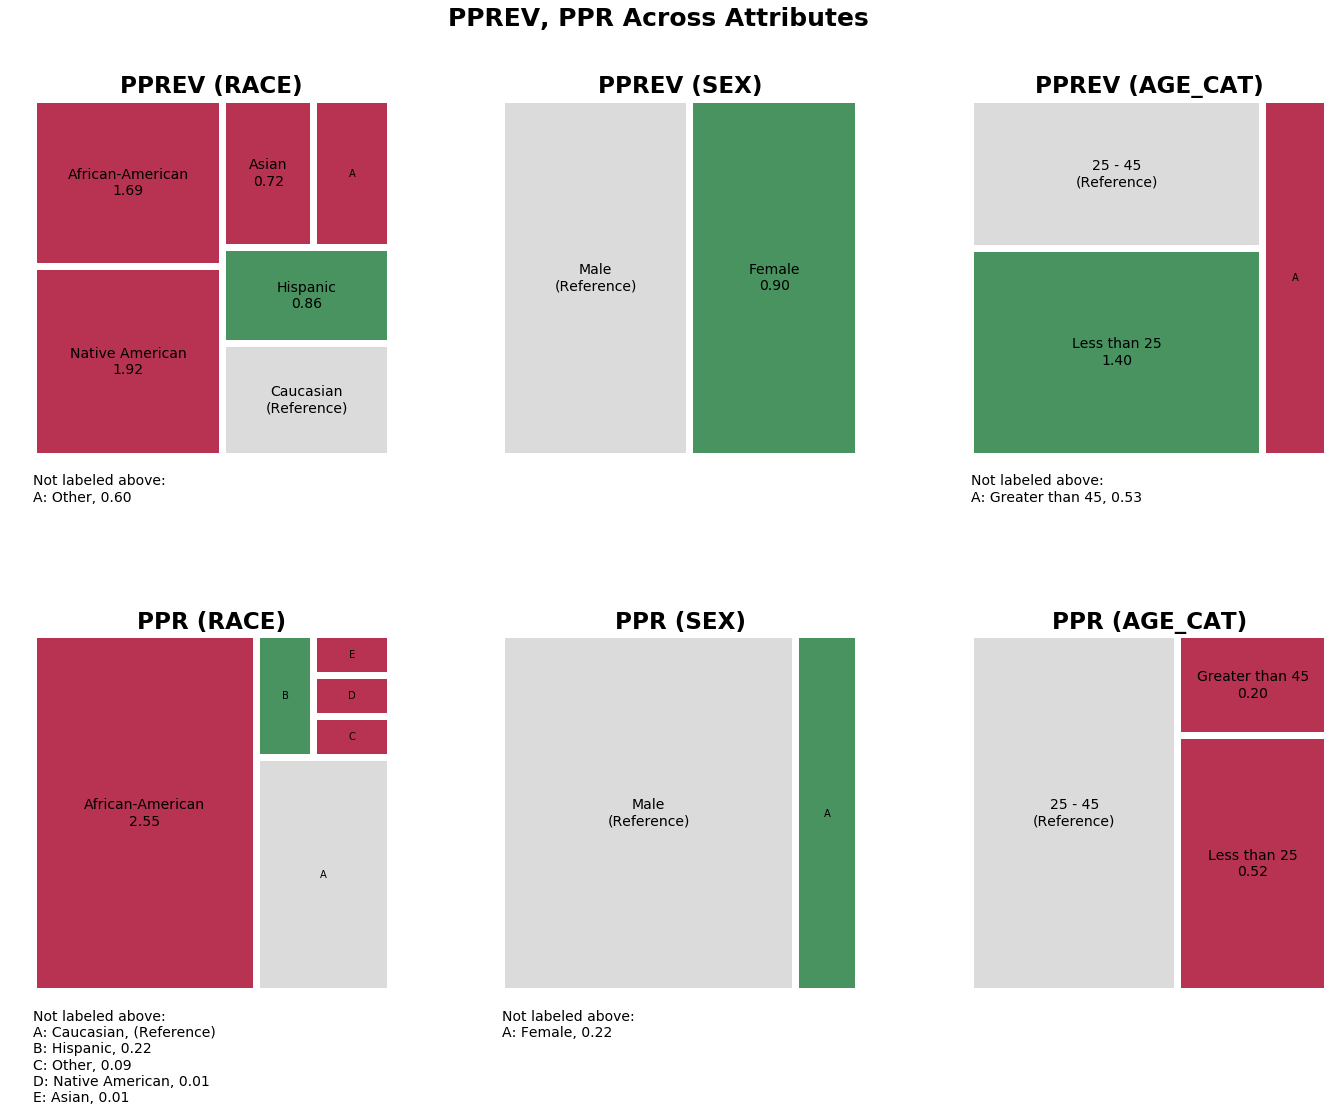

In [39]:
r_tm = aqp.plot_fairness_disparity_all(fdf, metrics=['pprev', 'ppr'])

### Specify default disparity metrics across multiple attributes 

The treemaps below display disparities between attribute groups for all two attributes (sex, age category) calculated based on predefined reference groups ('sex' attribute: Male, 'age_cat' attribute: 25-45) for the six default disparity metrics, colored based on fairness determination for that attribute group (green = 'True' and red = 'False').

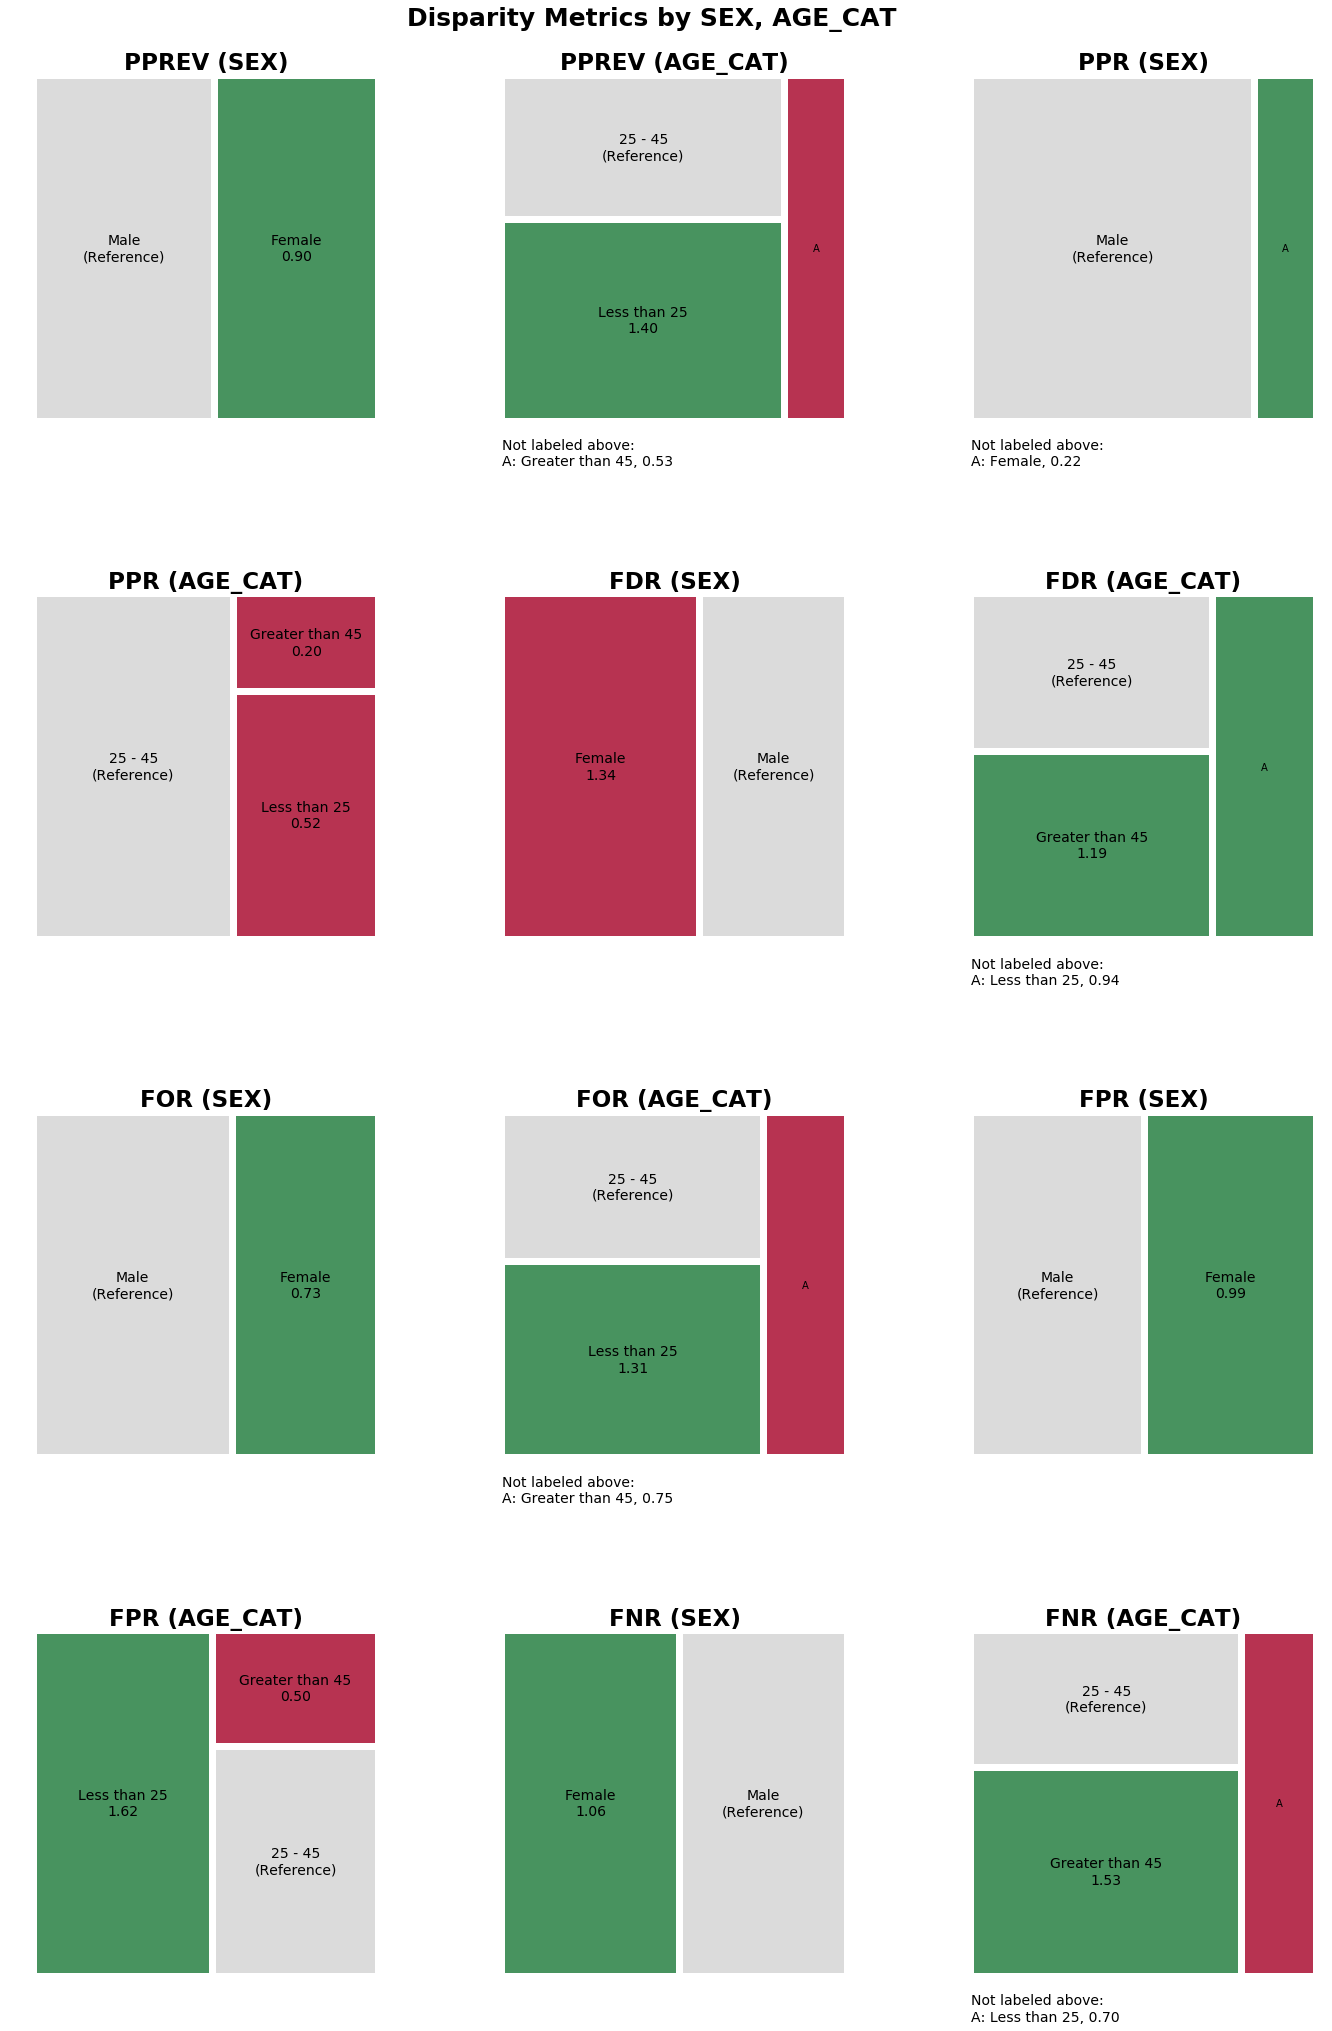

In [40]:
n_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['sex', 'age_cat'])

## The Aequitas Effect

By breaking down the COMPAS predictions using a variety of bias and disparity metrics calculated using different reference groups, we are able to surface the specific metrics for which our models are imposing bias on given attribute groups, and have a clearer lens when evaluating models and making recommendations for intervention.